In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Explore Measurement Database
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
# Explore Station Database
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

## Precipitation Analysis

In [15]:
# Find the latest date record along with its precipitation
session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()

('2017-08-23', 0.0)

In [82]:
# Calculate the date 1 year ago from the last data point in the database
a_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
a_year_ago

datetime.date(2016, 8, 23)

In [255]:
# Design a query to retrieve the last 12 months of precipitation data 
precipitation = session.query(Measurement.date, Measurement.prcp).\
                            filter(Measurement.date >= a_year_ago).\
                            order_by(Measurement.date.asc()).all()

In [256]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


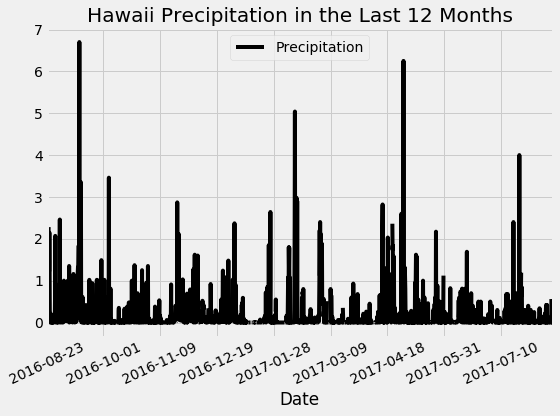

In [257]:
# Plot the results of the last 12 months of precepitation data
df.plot(title='Hawaii Precipitation in the Last 12 Months', color='black', figsize=(8,6))
plt.legend(loc='upper center')
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("Images/precipitation_histogram.png")
plt.show()

In [60]:
# Calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [104]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).count()
print(f'There are a total of {num_stations} stations.')

There are a total of 9 stations.


In [123]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
                         group_by(Measurement.station).\
                         order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [130]:
# Station with the highest number of observations
most_active = stations[0][0]
num_observations = stations[0][1]
print(f'The most active is station is {most_active} with {num_observations} observations.')

The most active is station is USC00519281 with 2772 observations.


In [173]:
# Using the station id from the previous query, calculate the lowest temperature recorded from the most active station
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()
lowest_temp

[('USC00519281', 54.0)]

In [175]:
# Calculate the highest temperature recorded from the most active station
highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()
highest_temp

[('USC00519281', 85.0)]

In [183]:
# Calculate the average temperature recorded from the most active station
average_temp = session.query(Measurement.station,func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
average_temp

[('USC00519281', 71.66378066378067)]

In [182]:
# Diplay the results
print(f'From the most active station {most_active}:')
print(f' - The lowest temperature is {lowest_temp[0][1]}')
print(f' - The highest temperature is {highest_temp[0][1]}')
print(f' - The average temperature is {round(average_temp[0][1],1)}')

From the most active station USC00519281:
 - The lowest temperature is 54.0
 - The highest temperature is 85.0
 - The average temperature is 71.7


In [259]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
temperature = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active).\
                    filter(Measurement.date >= a_year_ago).\
                    order_by(Measurement.date.asc()).all()
temp_df = pd.DataFrame(temperature, columns=['Temperature'])
temp_df.head()

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
5,73.0
6,78.0
7,77.0
8,78.0
9,80.0


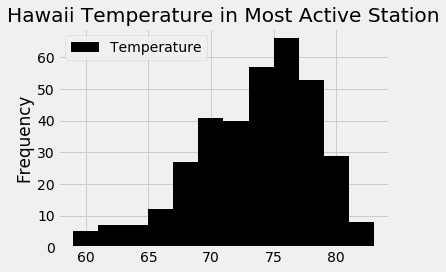

In [210]:
# Plot the results

temp_df.plot.hist(bins=12, title='Hawaii Temperature in Most Active Station', color='black')
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Images/most_active_station_histogram.png")
plt.show()

## Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [212]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-05-12','2017-05-20')
my_trip

[(68.0, 74.82, 79.0)]

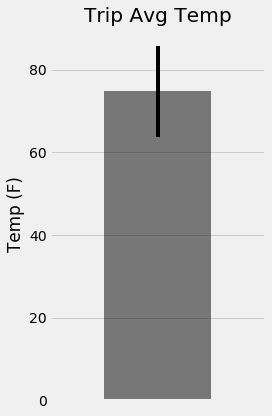

In [230]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_df = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])
my_trip_df.plot.bar(y='tavg', yerr=(my_trip_df['tmax'] - my_trip_df['tmin']), title='Trip Avg Temp', color='black', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel('Temp (F)')
plt.gca().legend_.remove()
plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")
plt.show()

In [231]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):

    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-05-12','2017-05-20'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.04), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
